In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
df = pd. read_csv('careem_data_with_time.csv', sep=';')
df.rename(columns={'Unnamed: 0':'Index'}, inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4768 entries, 0 to 4767
Data columns (total 13 columns):
Index               4768 non-null float64
user_id             4768 non-null object
ride_id             4768 non-null object
pick_up_time        4768 non-null int64
pick_up             4768 non-null object
pick_up_lat         4768 non-null float64
pick_up_lng         4768 non-null float64
pick_up_geohash     4768 non-null object
drop_off            4768 non-null object
drop_off_lat        4768 non-null float64
drop_off_lng        4768 non-null float64
drop_off_geohash    4768 non-null object
pickup_datetime     4768 non-null object
dtypes: float64(5), int64(1), object(7)
memory usage: 484.3+ KB


# Scatter Plot of user_id against drop_off (Note: Not all users are considered due to limited plot size, so 6 most frequent user_ids will be considered

In [4]:
#new dataframe -data- which has data for the top 6 users
lst =  'c8c41c4a18 bbd525a64d cc6ef8cb8d 358a71abf8 e4d22c51db faf890d407'.split(' ')
data = df.loc[ df['user_id'].isin(lst) ]

In [5]:
#Removing Sindh-Karachi from drop_off to make space for scatter plots

lst2 = list()
lst = list(data['drop_off'].values)
for i in range(0,len(data)):
    this=lst[i].split('-')[0:-2]
    lst2.append('-'.join(this))

In [6]:
data['drop_off'] = lst2

C:\Users\sohai\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


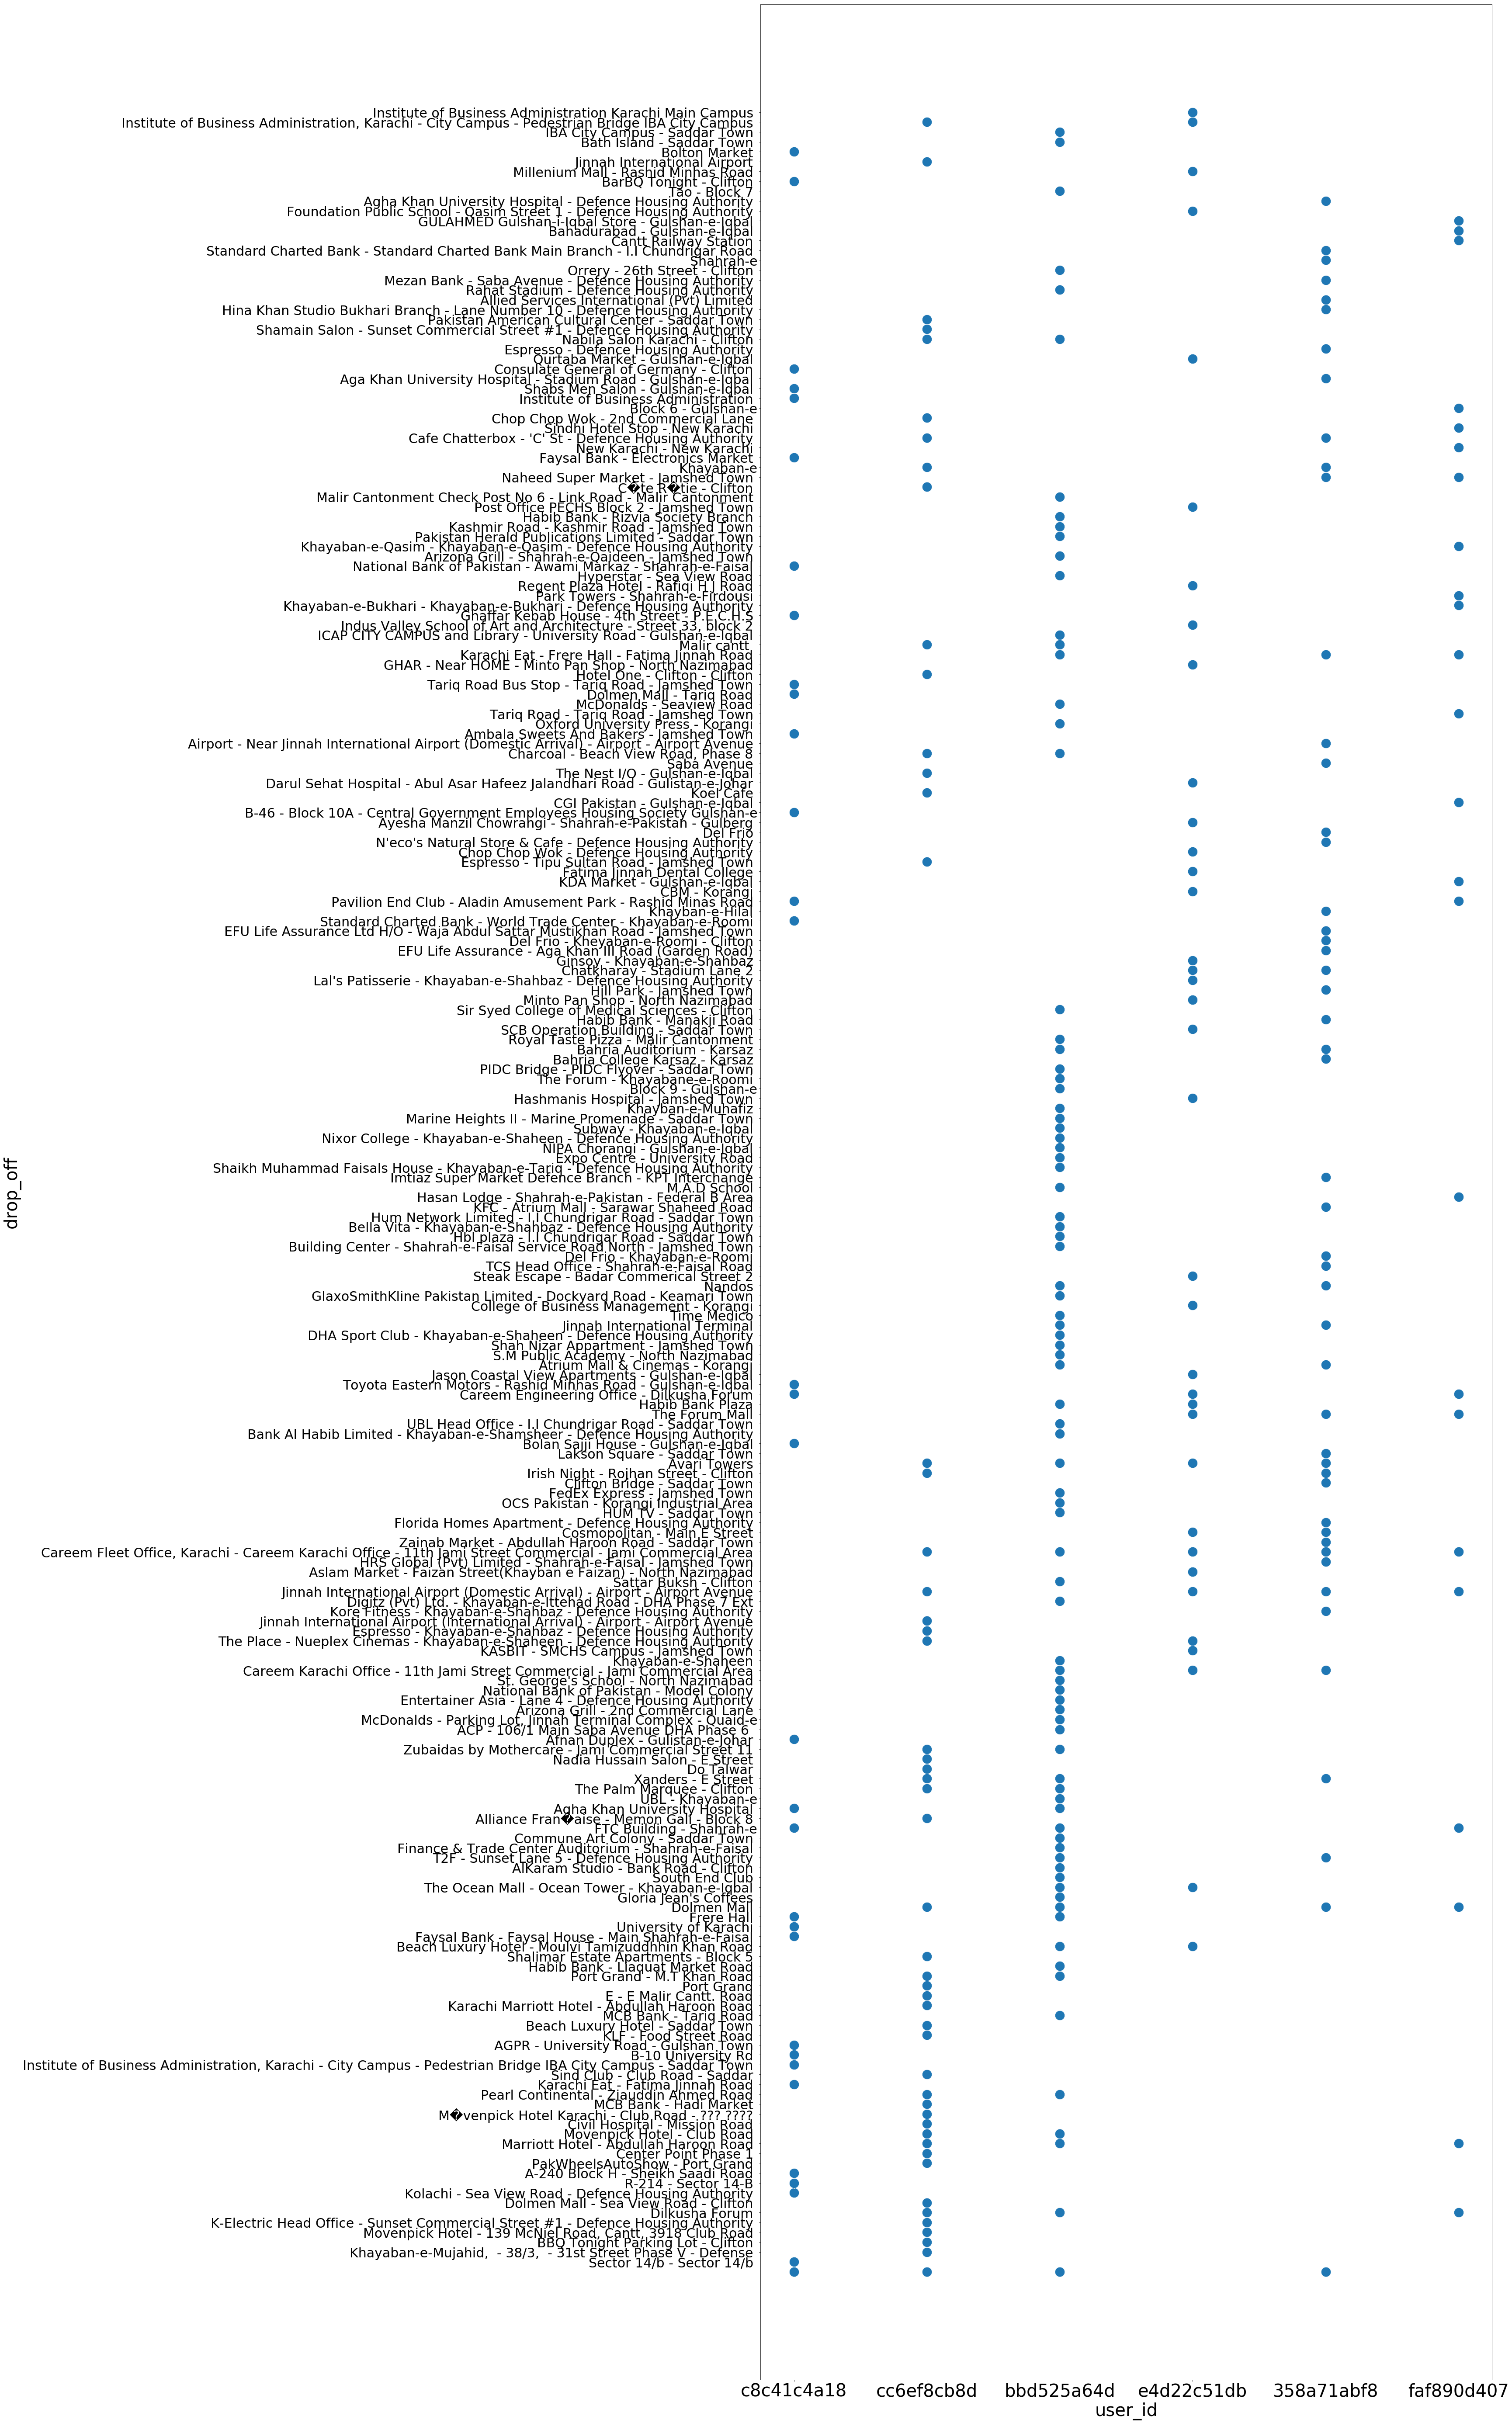

In [8]:
#plotting scatter plot
plt.figure(figsize=[30,100])
plt.ylabel('Drop_Off', fontsize=40)
plt.xlabel('User_ID', fontsize=40)
#plt.yticks(rotation=10)
sns.scatterplot(data['user_id'], data['drop_off'], s=500)
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 40


# Buidling Naive Bayes model based off of user_id as predictor/descriptive feature and target feature is of course Drop_off

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['user_id'], df['drop_off'], test_size=0.2, random_state=42)

In [11]:
mnb = MultinomialNB()
target = y_train.values
vct = CountVectorizer()
count = vct.fit_transform(X_train)
mnb.fit(count,target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [12]:
test_counts = vct.transform(X_test)
pred = mnb.predict(test_counts)
print(accuracy_score(y_test, pred))

0.2389937106918239


# The prediction accuracy for our first hypothesis turned out to be a dissapointing one, so lets check if our model would work any better considering time as our input .

Note that time is a countinous feature, therefore its sensible to convert to discrete by perform binning 

In [13]:
#discretizing time 
datetime = df['pickup_datetime'].values
time = list()
[time.append(datetime[i].split(' ')[1].split(':')) for i in range(len(datetime))]
time[1:3]

featured_time  = list()
for i in range(len(time)):
    if int(time[i][1]) > 30:
        t = int(time[i][0]) + 1
        featured_time.append(str(t))
    else: 
        t = int(time[i][0])
        featured_time.append(str(t))   

In [14]:
df['Featured_Time'] = featured_time

# Fitting NaiveBayes model as -discretized- time our descriptive feature

In [15]:
X_train, X_test, y_train, y_test = train_test_split(featured_time, df['drop_off'], test_size=0.3, random_state=42)
mnb = MultinomialNB()
target = y_train.values
vct = CountVectorizer()
count = vct.fit_transform(X_train)
mnb.fit(count, target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [16]:
test_counts = vct.transform(X_test)
pred = mnb.predict(test_counts)
print(accuracy_score(y_test, pred))

0.10412299091544375


# Prediction accuracy for our second hypothesis seems to be a more disappointing one of only 10%

# Lets give both of the previous input features a chance together

In [17]:
X = df[ ['user_id','Featured_Time']]
X_train, X_test, y_train, y_test = train_test_split(X, df['drop_off'], test_size=0.3, random_state=42)

In [18]:
(X_train['user_id'] + ' ' + X_train['Featured_Time']).head()

3998     1e75d5b086 7
299      194997da1d 7
1003     c04c75a581 9
382      d4430a5a0c 6
941     2d1bafe55b 17
dtype: object

In [19]:
mnb = MultinomialNB()
target = y_train.values
vct = CountVectorizer()
count = vct.fit_transform(X_train['user_id'] + ' ' + X_train['Featured_Time'])
mnb.fit(count, target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
test_counts = vct.transform(X_test['user_id'] + ' ' + X_test['Featured_Time'])
pred = mnb.predict(test_counts)
print(accuracy_score(y_test,pred))

0.25925925925925924


# Prediction Accuracy of about 30% seems a bit promising for our 3rd hypothesis 

# I will be fitting NB model once again but this time with pick_up as the input feature


In [21]:
X = df['pick_up']
X_train, X_test, y_train, y_test = train_test_split(X, df['drop_off'], test_size=0.3, random_state=42)
mnb = MultinomialNB()
target = y_train.values
vct = CountVectorizer()
count = vct.fit_transform(X_train.values.tolist())
mnb.fit(count, target)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [22]:
test_counts = vct.transform(X_test)
pred = mnb.predict(test_counts)
print(accuracy_score(y_test, pred))

0.18658280922431866


# Nahh, this didn't work as well, this means there's one major problem that we have been overlooking

Problem : The careem dataset contains the data of various user's ride history. Therefore, it doesn't make any sense to predict destination of a specific user on the basis of other user's activities. 

Specific user's history ought to be considered for prediction. 

# Scatter Plot for user_id 'c8c41c4a18' against drop_off

In [23]:
#Removing Sindh-Karachi from drop_off to make space for scatter plots

lst2 = list()
lst = list(df['drop_off'].values)
for i in range(0,len(df)):
    this=lst[i].split('-')[0:-2]
    lst2.append('-'.join(this))


In [24]:
df['drop_off'] = lst2

In [25]:
dfusr = df[ df['user_id'] == 'c8c41c4a18' ]

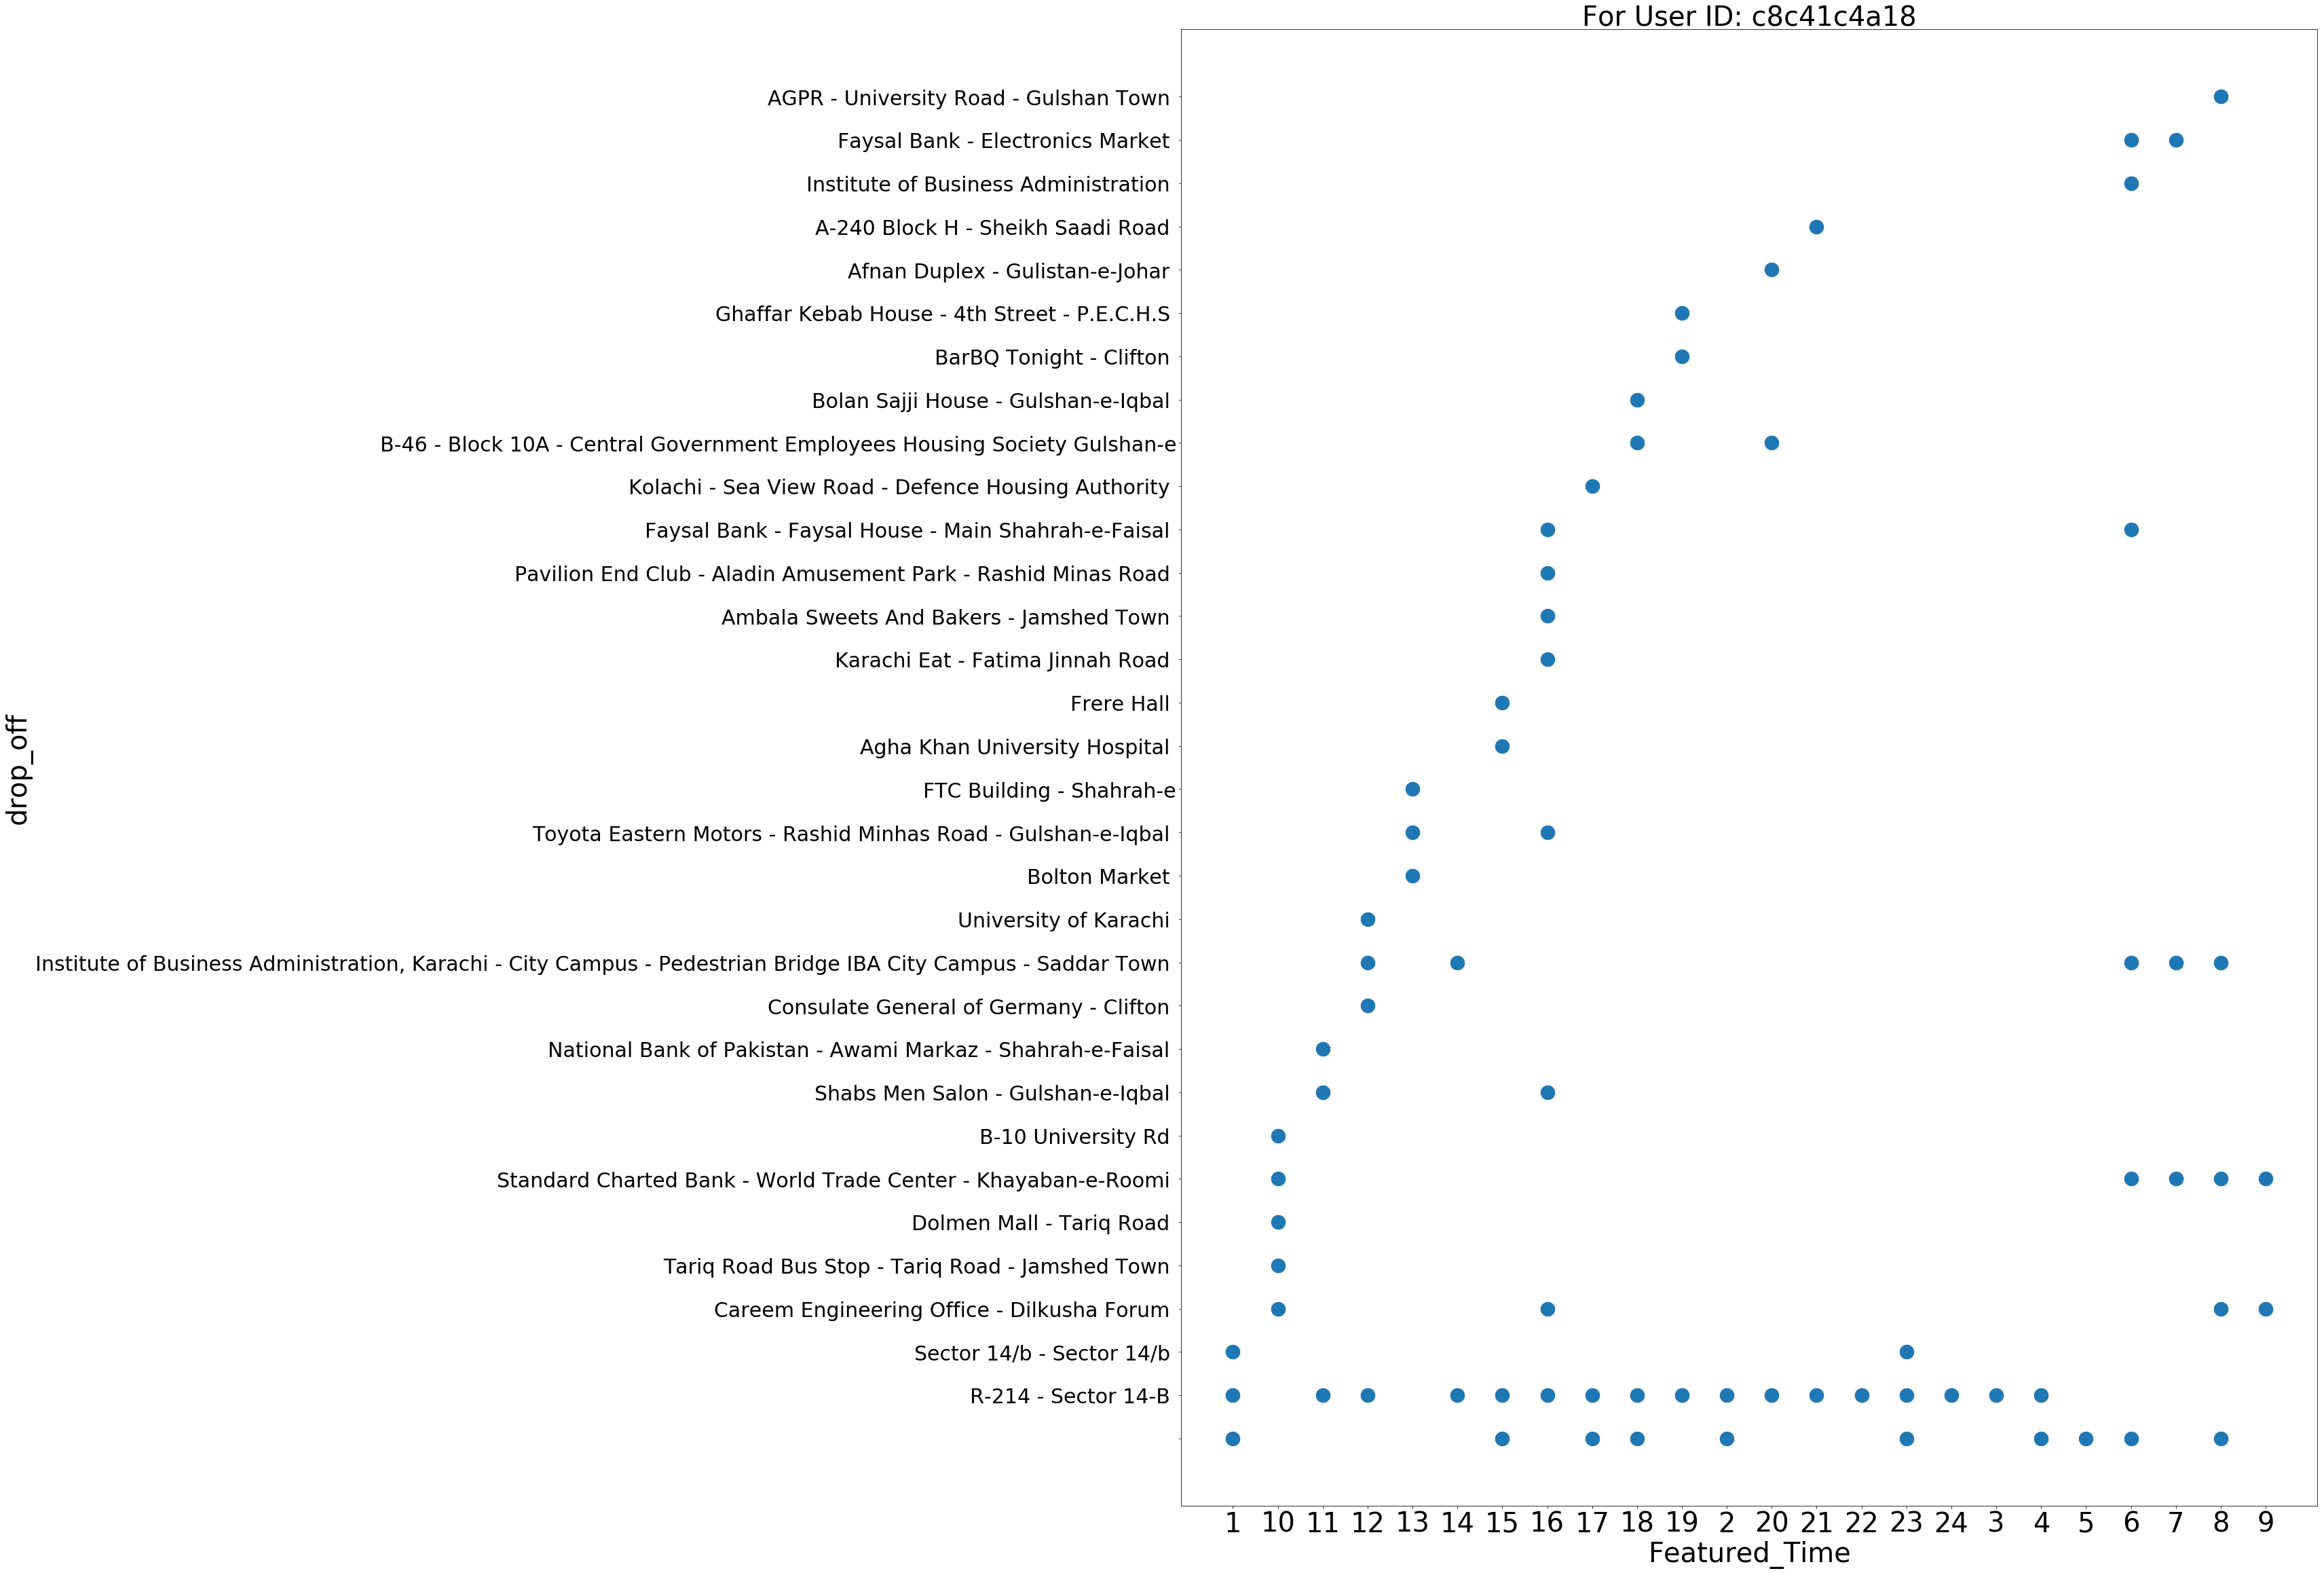

In [26]:
dfusr1 = dfusr.sort_values(by='Featured_Time')
plt.figure(figsize=[30,40])
plt.title('For User ID: c8c41c4a18' , fontsize=40)
plt.ylabel('Drop_Off', fontsize=40)
plt.xlabel('Featured_Time', fontsize=40)
#plt.yticks(rotation=10)
sns.scatterplot(dfusr1['Featured_Time'], dfusr1['drop_off'], s=500)
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 30

# I will consider pick_up as input feature as before but this time with only a particular user's data, so the most frequent user 'c8c41c4a18' will be considered

In [27]:
#X = dfusr[ ['user_id','Featured_Time']]
X = dfusr['pick_up']
X_train, X_test, y_train, y_test = train_test_split(X, dfusr['drop_off'], test_size=0.3, random_state=42)
mnb = MultinomialNB()
target = y_train.values
vct = CountVectorizer()
count = vct.fit_transform(X_train.values.tolist())
mnb.fit(count, target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
test_counts = vct.transform(X_test)
pred = mnb.predict(test_counts)
print(accuracy_score(y_test, pred))

0.6835443037974683


# Finally!!!! something to cheer about, prediction accuracy of about 70%

In [29]:
#X = dfusr[ ['user_id','Featured_Time']]
X = dfusr['Featured_Time']
X_train, X_test, y_train, y_test = train_test_split(X, dfusr['drop_off'], test_size=0.3, random_state=42)
mnb = MultinomialNB()
target = y_train.values
vct = CountVectorizer()
count = vct.fit_transform(X_train.values.tolist())
mnb.fit(count, target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [30]:
test_counts = vct.transform(X_test)
pred = mnb.predict(test_counts)
print(accuracy_score(y_test, pred))

0.43037974683544306


# Prediction accuracy is 43% for our last hyopthesis (Feature_Time as input feature) which  is a lot better than before, which was 16%